<a href="https://colab.research.google.com/github/lLoLii/xgboost-mental-state-v2/blob/master/xgboost_mentalstatev2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is for training a mental states classifier using XGBooster model 

[Data](https://www.kaggle.com/birdy654/eeg-mental-state-v2)

Due to little information about the dataset, so I'm using the information that the author provided in [mental-state-v1](https://www.kaggle.com/birdy654/eeg-brainwave-dataset-mental-state)

Label : 0,        1,       2

positive, neutral, negative.

**Import packages and data**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore') 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
eeg = pd.read_csv('/content/drive/My Drive/Projects/mental_state_v2/mental-state-v2.csv')

**Exploration and preprocessing**

In [0]:
eeg.head()

,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_q1_0,lag1_mean_q1_1,lag1_mean_q1_2,lag1_mean_q1_3,lag1_mean_q2_0,lag1_mean_q2_1,lag1_mean_q2_2,lag1_mean_q2_3,lag1_mean_d_q1q2_0,lag1_mean_d_q1q2_1,lag1_mean_d_q1q2_2,lag1_mean_d_q1q2_3,lag1_mean_d_q1q3_0,lag1_mean_d_q1q3_1,lag1_mean_d_q1q3_2,lag1_mean_d_q1q3_3,lag1_mean_d_q1q4_0,lag1_mean_d_q1q4_1,lag1_mean_d_q1q4_2,lag1_mean_d_q1q4_3,lag1_mean_d_q2q3_0,lag1_mean_d_q2q3_1,lag1_mean_d_q2q3_2,lag1_mean_d_q2q3_3,lag1_mean_d_q2q4_0,lag1_mean_d_q2q4_1,lag1_mean_d_q2q4_2,lag1_mean_d_q2q4_3,lag1_std_0,lag1_std_1,lag1_std_2,lag1_std_3,...,freq_345_3,freq_355_3,freq_365_3,freq_375_3,freq_385_3,freq_395_3,freq_405_3,freq_416_3,freq_426_3,freq_436_3,freq_446_3,freq_456_3,freq_466_3,freq_476_3,freq_486_3,freq_517_3,freq_527_3,freq_537_3,freq_547_3,freq_557_3,freq_568_3,freq_578_3,freq_588_3,freq_598_3,freq_608_3,freq_618_3,freq_628_3,freq_639_3,freq_649_3,freq_659_3,freq_669_3,freq_679_3,freq_689_3,freq_699_3,freq_709_3,freq_720_3,freq_730_3,freq_740_3,freq_750_3,Label
0,25.781648,33.836367,-92.769629,19.187957,-1.542262,0.197462,-119.561133,2.032654,21.596272,33.965587,-44.185210,20.566772,31.378853,33.515684,-22.087550,15.839519,-9.782581,0.449903,-22.097661,4.727253,-7.842261,-1.777093,388.176808,-2.378340,0.897242,1.790503,-164.083369,3.031188,1.940320,-2.226997,410.274469,-7.105593,10.679824,1.340600,-141.985708,-1.696065,12.540533,3.361502,296.058029,8.061738,...,0.000155,0.000327,0.000436,0.000713,0.000972,0.000383,0.000590,0.000428,0.000931,0.000256,0.000476,0.000876,0.000418,0.000990,0.000487,0.000218,0.000248,0.000890,0.000357,0.000178,0.000559,0.000398,0.000281,0.000167,0.000513,0.000671,0.000408,0.000640,0.000673,0.000579,0.000230,0.000351,0.000547,0.000381,0.000350,0.000453,0.000442,0.000325,0.000209,2.0
1,29.357891,26.792566,417.203910,19.472121,-38.797263,-16.897194,-29.368531,-9.055370,44.647424,40.893307,383.877655,26.973276,52.757486,29.737761,478.635262,21.104585,-8.110062,11.155546,-94.757607,5.868691,26.429449,16.225081,-38.363980,9.087526,42.729546,28.707166,0.561000,14.892750,34.539512,5.069535,56.393628,3.218836,50.839608,17.551620,95.318607,9.024059,29.988771,13.938704,302.233628,11.915397,...,0.001469,0.001069,0.000699,0.000843,0.000977,0.000937,0.001829,0.000811,0.000425,0.000990,0.000455,0.000608,0.000416,0.000515,0.000427,0.000831,0.000484,0.000948,0.000570,0.000747,0.000223,0.000412,0.000782,0.000939,0.000051,0.000781,0.000774,0.001282,0.000112,0.000448,0.001671,0.000740,0.001122,0.000521,0.000624,0.000439,0.001249,0.000727,0.000801,2.0
2,28.451926,31.076434,72.231301,14.245938,-13.225057,-0.614138,-28.331698,-8.858742,31.450289,30.692883,112.487661,23.340511,38.583510,32.055949,60.993231,14.132874,-7.133221,-1.363066,51.494430,9.207637,19.643280,0.971452,57.689732,11.479376,-0.157486,-1.096838,51.240673,15.514708,26.776501,2.334518,6.195302,2.271739,6.975736,0.266227,-0.253757,6.307071,18.873047,3.754739,306.658171,8.292373,...,0.000638,0.000649,0.001017,0.001607,0.000941,0.001073,0.001985,0.000824,0.000726,0.000595,0.001129,0.000463,0.000124,0.000836,0.000929,0.001708,0.000693,0.001168,0.000640,0.001060,0.001455,0.001978,0.000640,0.000669,0.000918,0.000830,0.000577,0.000537,0.000824,0.001028,0.000748,0.000569,0.000327,0.000197,0.000833,0.000909,0.000699,0.001165,0.000616,2.0
3,21.282184,19.985184,16.220094,39.787312,1.847866,0.670216,-1.820355,20.220724,21.404679,20.777411,18.611532,29.742982,19.339359,18.552407,15.687991,29.612657,2.065319,2.225004,2.923541,0.130326,-0.503348,3.487670,-3.277967,-16.382968,-1.091683,-2.493681,9.708051,-23.827160,-2.568668,1.262666,-6.201508,-16.513294,-3.157003,-4.718685,6.784510,-23.957486,9.643293,5.965397,7.867285,13.315657,...,0.034677,0.001491,0.008073,0.004832,0.014095,0.014023,0.020398,0.009647,0.025453,0.022951,0.019648,0.020112,0.013159,0.013036,0.018927,0.021292,0.019478,0.014137,0.009725,0.011044,0.010982,0.009246,0.008073,0.0158

In [0]:
eeg.tail()

,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_q1_0,lag1_mean_q1_1,lag1_mean_q1_2,lag1_mean_q1_3,lag1_mean_q2_0,lag1_mean_q2_1,lag1_mean_q2_2,lag1_mean_q2_3,lag1_mean_d_q1q2_0,lag1_mean_d_q1q2_1,lag1_mean_d_q1q2_2,lag1_mean_d_q1q2_3,lag1_mean_d_q1q3_0,lag1_mean_d_q1q3_1,lag1_mean_d_q1q3_2,lag1_mean_d_q1q3_3,lag1_mean_d_q1q4_0,lag1_mean_d_q1q4_1,lag1_mean_d_q1q4_2,lag1_mean_d_q1q4_3,lag1_mean_d_q2q3_0,lag1_mean_d_q2q3_1,lag1_mean_d_q2q3_2,lag1_mean_d_q2q3_3,lag1_mean_d_q2q4_0,lag1_mean_d_q2q4_1,lag1_mean_d_q2q4_2,lag1_mean_d_q2q4_3,lag1_std_0,lag1_std_1,lag1_std_2,lag1_std_3,...,freq_345_3,freq_355_3,freq_365_3,freq_375_3,freq_385_3,freq_395_3,freq_405_3,freq_416_3,freq_426_3,freq_436_3,freq_446_3,freq_456_3,freq_466_3,freq_476_3,freq_486_3,freq_517_3,freq_527_3,freq_537_3,freq_547_3,freq_557_3,freq_568_3,freq_578_3,freq_588_3,freq_598_3,freq_608_3,freq_618_3,freq_628_3,freq_639_3,freq_649_3,freq_659_3,freq_669_3,freq_679_3,freq_689_3,freq_699_3,freq_709_3,freq_720_3,freq_730_3,freq_740_3,freq_750_3,Label
2148,30.691148,-31.091707,26.287078,26.842125,8.294064,26.946822,-4.441319,-7.735403,26.977287,-63.973499,30.855553,39.761591,26.122346,-25.667484,26.221707,21.896267,0.854941,-38.306015,4.633846,17.865325,-12.502868,-57.404370,10.415956,15.709953,-3.341077,-35.596803,3.257756,17.836035,-13.357809,-19.098355,5.782109,-2.155372,-4.196018,2.709213,-1.376091,-0.029290,9.764235,46.806772,8.632385,11.092973,...,0.001076,0.003989,0.021736,0.006932,0.022465,0.009340,0.006871,0.004232,0.011647,0.001897,0.008314,0.006652,0.004442,0.002058,0.003925,0.008037,0.003929,0.010954,0.005402,0.013584,0.004854,0.010856,0.005431,0.012425,0.008037,0.006817,0.009182,0.007142,0.010778,0.005412,0.009668,0.005261,0.006778,0.003788,0.005694,0.004122,0.008907,0.005087,0.009000,2.0
2149,14.762875,34.435313,42.276391,12.029633,-7.418017,11.792327,27.480496,-5.183748,21.448152,30.156122,35.813118,16.356109,15.573938,26.964729,21.450667,12.932552,5.874214,3.191393,14.362451,3.423557,31.546645,4.738257,-13.953768,25.573261,-10.201433,-24.696502,-26.288806,-11.245642,25.672431,1.546864,-28.316220,22.149704,-16.075647,-27.887894,-40.651257,-14.669199,30.409734,15.353427,21.949792,29.931609,...,0.010396,0.012114,0.013235,0.007780,0.008399,0.002666,0.009555,0.004423,0.002513,0.003528,0.008867,0.005661,0.005664,0.004159,0.007001,0.006736,0.005315,0.006504,0.004810,0.003618,0.002868,0.003214,0.009427,0.008024,0.003452,0.006867,0.004859,0.001751,0.005692,0.004647,0.002921,0.003466,0.008010,0.001600,0.000471,0.005678,0.005987,0.001698,0.003415,1.0
2150,45.670447,37.154973,-102.535272,12.305837,-13.360528,-18.020290,452.601193,-32.260524,44.598342,43.611204,-413.508001,21.438675,59.899071,48.651823,-246.391951,35.249379,-15.300728,-5.040619,-167.116050,-13.810705,82.383085,15.217833,-444.678986,72.968851,-69.146375,15.708380,-627.430971,-21.187236,97.683813,20.258452,-277.562936,86.779555,-53.845647,20.748998,-460.314921,-7.376532,93.223143,14.128716,308.103220,70.610007,...,0.001623,0.001489,0.002260,0.003192,0.000931,0.001249,0.002893,0.000915,0.000906,0.003814,0.003043,0.002673,0.001720,0.004023,0.002986,0.005048,0.003022,0.003542,0.003575,0.001562,0.004688,0.000819,0.002772,0.002245,0.005841,0.004390,0.003137,0.001303,0.006048,0.005197,0.002336,0.000591,0.000768,0.000702,0.001987,0.002353,0.001754,0.002299,0.005434,2.0
2151,23.437477,19.193664,22.190121,26.626578,1.869182,1.518235,2.993154,0.555913,21.500708,20.194401,23.573855,22.768808,23.478691,16.721004,17.889031,29.834229,-1.977983,3.473397,5.684824,-7.065421,-2.808847,4.804067,2.051639,-7.025607,-2.932228,-4.200763,-2.220365,-1.321895,-0.830863,1.330670,-3.633184,0.039814,-0.954245,-7.674160,-7.905189,5.743526,9.207782,6.575544,7.907499,9.694995,...,0.014507,0.020790,0.022446,0.028789,0.010406,0.032509,0.024035,0.020287,0.016673,0.014669,0.014024,0.012712,0.033439,0.017969,0.017661,0.025542,0.008212,0.003998,0.010235,0.0

The last row has NaN values , and i decided to drop the row. 

In [0]:
eeg.dropna(inplace=True)

In [0]:
eeg.shape

(2152, 989)

In [0]:
print(eeg.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2152 entries, 0 to 2151
Data columns (total 989 columns):
 #   Column              Dtype  
---  ------              -----  
 0   lag1_mean_0         float64
 1   lag1_mean_1         float64
 2   lag1_mean_2         float64
 3   lag1_mean_3         float64
 4   lag1_mean_d_h2h1_0  float64
 5   lag1_mean_d_h2h1_1  float64
 6   lag1_mean_d_h2h1_2  float64
 7   lag1_mean_d_h2h1_3  float64
 8   lag1_mean_q1_0      float64
 9   lag1_mean_q1_1      float64
 10  lag1_mean_q1_2      float64
 11  lag1_mean_q1_3      float64
 12  lag1_mean_q2_0      float64
 13  lag1_mean_q2_1      float64
 14  lag1_mean_q2_2      float64
 15  lag1_mean_q2_3      float64
 16  lag1_mean_d_q1q2_0  float64
 17  lag1_mean_d_q1q2_1  float64
 18  lag1_mean_d_q1q2_2  float64
 19  lag1_mean_d_q1q2_3  float64
 20  lag1_mean_d_q1q3_0  float64
 21  lag1_mean_d_q1q3_1  float64
 22  lag1_mean_d_q1q3_2  float64
 23  lag1_mean_d_q1q3_3  float64
 24  lag1_mean_d_q1q4_0  float64
 

In [0]:
eeg['Label'] = eeg['Label'].astype('int')

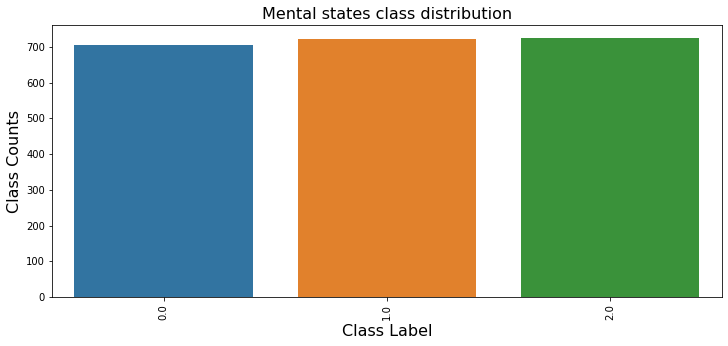

In [0]:
plt.figure(figsize=(12,5))
sns.countplot(x='Label',data=eeg)
plt.title('Mental states class distribution', fontsize=16)
plt.ylabel('Class Counts', fontsize=16)
plt.xlabel('Class Label', fontsize=16)
plt.xticks(rotation='vertical');

In [0]:
label = eeg['Label']

eeg.drop(['Label'], axis = 1, inplace=True)

In [0]:
eeg

,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_q1_0,lag1_mean_q1_1,lag1_mean_q1_2,lag1_mean_q1_3,lag1_mean_q2_0,lag1_mean_q2_1,lag1_mean_q2_2,lag1_mean_q2_3,lag1_mean_d_q1q2_0,lag1_mean_d_q1q2_1,lag1_mean_d_q1q2_2,lag1_mean_d_q1q2_3,lag1_mean_d_q1q3_0,lag1_mean_d_q1q3_1,lag1_mean_d_q1q3_2,lag1_mean_d_q1q3_3,lag1_mean_d_q1q4_0,lag1_mean_d_q1q4_1,lag1_mean_d_q1q4_2,lag1_mean_d_q1q4_3,lag1_mean_d_q2q3_0,lag1_mean_d_q2q3_1,lag1_mean_d_q2q3_2,lag1_mean_d_q2q3_3,lag1_mean_d_q2q4_0,lag1_mean_d_q2q4_1,lag1_mean_d_q2q4_2,lag1_mean_d_q2q4_3,lag1_std_0,lag1_std_1,lag1_std_2,lag1_std_3,...,freq_334_3,freq_345_3,freq_355_3,freq_365_3,freq_375_3,freq_385_3,freq_395_3,freq_405_3,freq_416_3,freq_426_3,freq_436_3,freq_446_3,freq_456_3,freq_466_3,freq_476_3,freq_486_3,freq_517_3,freq_527_3,freq_537_3,freq_547_3,freq_557_3,freq_568_3,freq_578_3,freq_588_3,freq_598_3,freq_608_3,freq_618_3,freq_628_3,freq_639_3,freq_649_3,freq_659_3,freq_669_3,freq_679_3,freq_689_3,freq_699_3,freq_709_3,freq_720_3,freq_730_3,freq_740_3,freq_750_3
0,25.781648,33.836367,-92.769629,19.187957,-1.542262,0.197462,-119.561133,2.032654,21.596272,33.965587,-44.185210,20.566772,31.378853,33.515684,-22.087550,15.839519,-9.782581,0.449903,-22.097661,4.727253,-7.842261,-1.777093,388.176808,-2.378340,0.897242,1.790503,-164.083369,3.031188,1.940320,-2.226997,410.274469,-7.105593,10.679824,1.340600,-141.985708,-1.696065,12.540533,3.361502,296.058029,8.061738,...,0.000442,0.000155,0.000327,0.000436,0.000713,0.000972,0.000383,0.000590,0.000428,0.000931,0.000256,0.000476,0.000876,0.000418,0.000990,0.000487,0.000218,0.000248,0.000890,0.000357,0.000178,0.000559,0.000398,0.000281,0.000167,0.000513,0.000671,0.000408,0.000640,0.000673,0.000579,0.000230,0.000351,0.000547,0.000381,0.000350,0.000453,0.000442,0.000325,0.000209
1,29.357891,26.792566,417.203910,19.472121,-38.797263,-16.897194,-29.368531,-9.055370,44.647424,40.893307,383.877655,26.973276,52.757486,29.737761,478.635262,21.104585,-8.110062,11.155546,-94.757607,5.868691,26.429449,16.225081,-38.363980,9.087526,42.729546,28.707166,0.561000,14.892750,34.539512,5.069535,56.393628,3.218836,50.839608,17.551620,95.318607,9.024059,29.988771,13.938704,302.233628,11.915397,...,0.001407,0.001469,0.001069,0.000699,0.000843,0.000977,0.000937,0.001829,0.000811,0.000425,0.000990,0.000455,0.000608,0.000416,0.000515,0.000427,0.000831,0.000484,0.000948,0.000570,0.000747,0.000223,0.000412,0.000782,0.000939,0.000051,0.000781,0.000774,0.001282,0.000112,0.000448,0.001671,0.000740,0.001122,0.000521,0.000624,0.000439,0.001249,0.000727,0.000801
2,28.451926,31.076434,72.231301,14.245938,-13.225057,-0.614138,-28.331698,-8.858742,31.450289,30.692883,112.487661,23.340511,38.583510,32.055949,60.993231,14.132874,-7.133221,-1.363066,51.494430,9.207637,19.643280,0.971452,57.689732,11.479376,-0.157486,-1.096838,51.240673,15.514708,26.776501,2.334518,6.195302,2.271739,6.975736,0.266227,-0.253757,6.307071,18.873047,3.754739,306.658171,8.292373,...,0.001561,0.000638,0.000649,0.001017,0.001607,0.000941,0.001073,0.001985,0.000824,0.000726,0.000595,0.001129,0.000463,0.000124,0.000836,0.000929,0.001708,0.000693,0.001168,0.000640,0.001060,0.001455,0.001978,0.000640,0.000669,0.000918,0.000830,0.000577,0.000537,0.000824,0.001028,0.000748,0.000569,0.000327,0.000197,0.000833,0.000909,0.000699,0.001165,0.000616
3,21.282184,19.985184,16.220094,39.787312,1.847866,0.670216,-1.820355,20.220724,21.404679,20.777411,18.611532,29.742982,19.339359,18.552407,15.687991,29.612657,2.065319,2.225004,2.923541,0.130326,-0.503348,3.487670,-3.277967,-16.382968,-1.091683,-2.493681,9.708051,-23.827160,-2.568668,1.262666,-6.201508,-16.513294,-3.157003,-4.718685,6.784510,-23.957486,9.643293,5.965397,7.867285,13.315657,...,0.037583,0.034677,0.001491,0.008073,0.004832,0.014095,0.014023,0.020398,0.009647,0.025453,0.022951,0.019648,0.020112,0.013159,0.013036,0.018927,0.021292,0.019478,0.014137,0.009725,0.011044,0.01

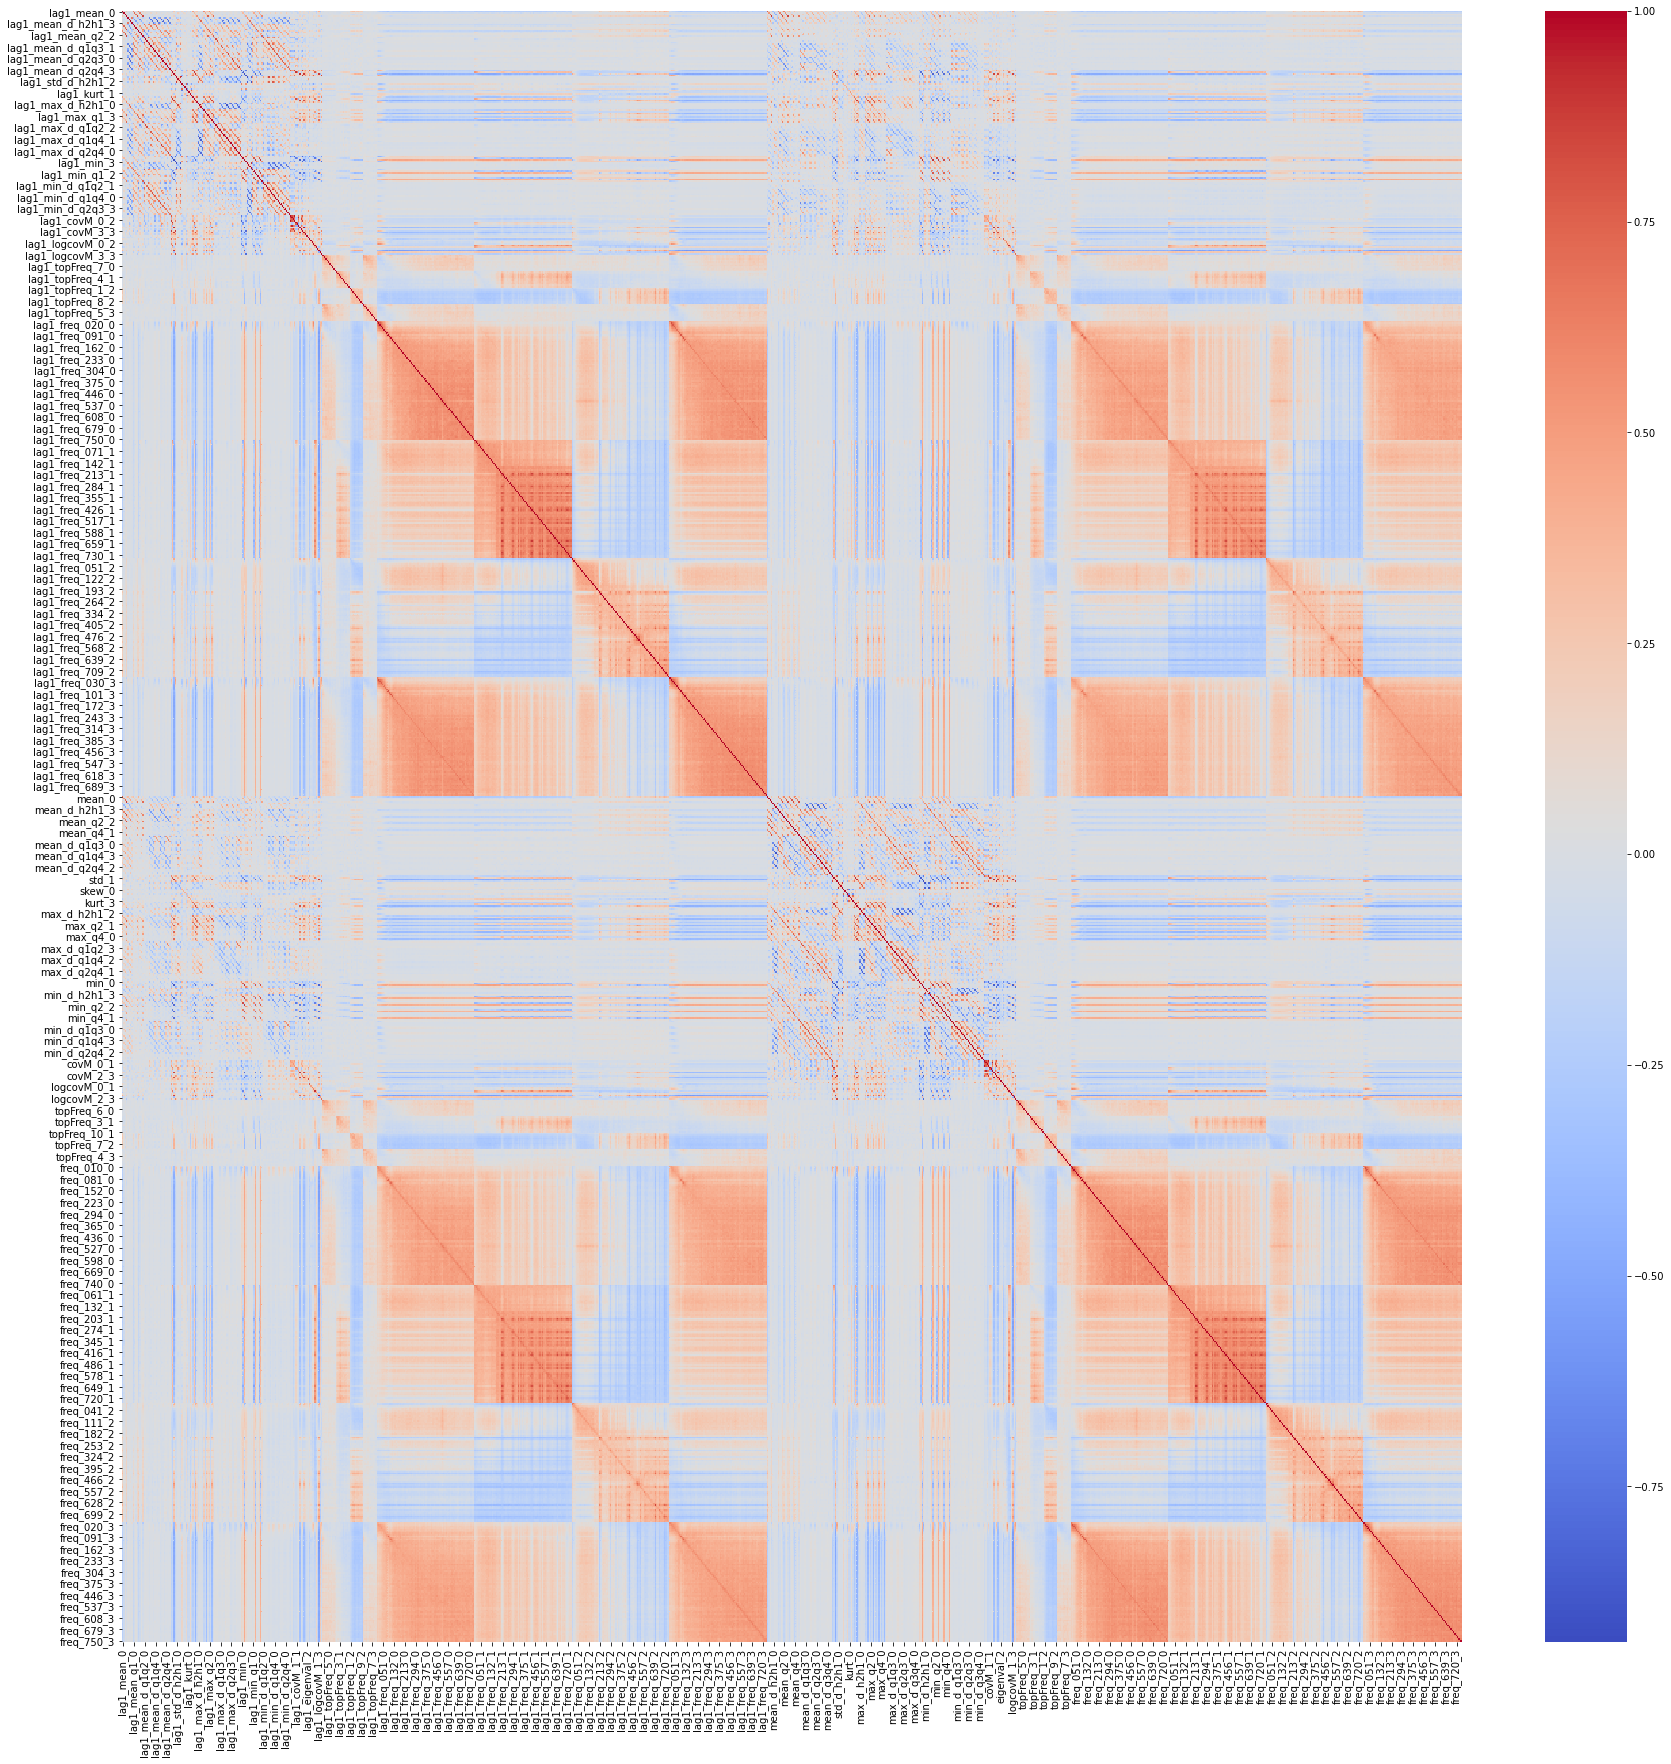

In [0]:
plt.figure(figsize=(30,30))
sns.heatmap(eeg.corr(),cmap='coolwarm')

**Split data by train , test , and validation**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(eeg, label, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [0]:
evalset = [(X_train, y_train), (X_test, y_test)]

**Define the model**

In [0]:
xgbmodel = xgb.XGBClassifier(
    max_depth = 6,
    learning_rate = 0.03,
    n_estimators = 300,
    objective='multi:softmax')

**Train**

In [0]:
r = xgbmodel.fit(X_train,y_train,eval_metric=['merror','mlogloss'], eval_set=evalset, verbose=True)

[0]	validation_0-merror:0.018605	validation_0-mlogloss:1.05902	validation_1-merror:0.078886	validation_1-mlogloss:1.06361
[1]	validation_0-merror:0.014729	validation_0-mlogloss:1.02086	validation_1-merror:0.071926	validation_1-mlogloss:1.02983
[2]	validation_0-merror:0.010853	validation_0-mlogloss:0.984213	validation_1-merror:0.064965	validation_1-mlogloss:0.997354
[3]	validation_0-merror:0.008527	validation_0-mlogloss:0.949593	validation_1-merror:0.055684	validation_1-mlogloss:0.96635
[4]	validation_0-merror:0.007752	validation_0-mlogloss:0.916475	validation_1-merror:0.053364	validation_1-mlogloss:0.936975
[5]	validation_0-merror:0.007752	validation_0-mlogloss:0.885422	validation_1-merror:0.053364	validation_1-mlogloss:0.909218
[6]	validation_0-merror:0.005426	validation_0-mlogloss:0.855888	validation_1-merror:0.051044	validation_1-mlogloss:0.88331
[7]	validation_0-merror:0.003876	validation_0-mlogloss:0.827419	validation_1-merror:0.046404	validation_1-mlogloss:0.857759
[8]	validation

**Plot learning curve**

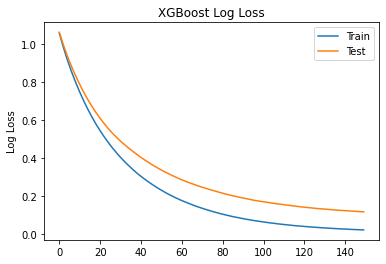

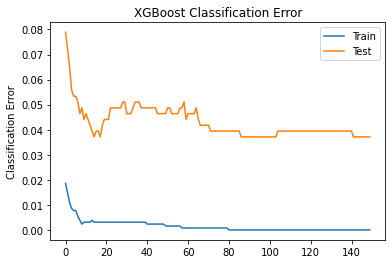

In [0]:
results = xgbmodel.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

**Predict on test data**

In [0]:
preds = xgbmodel.predict(X_test)

In [0]:
acc = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (acc * 100.0))

Accuracy: 97.22%


**Predict on validation data**

In [0]:
val_pred = xgbmodel.predict(X_val)
val_acc = accuracy_score(y_val, val_pred)

In [0]:
print("Validation Accuracy: %.2f%%" % (val_acc * 100.0))

Validation Accuracy: 97.45%


**Save model**

In [0]:
import pickle

In [0]:
pickle.dump(xgbmodel,open("/content/drive/My Drive/Projects/mental_state_v2/xgb-msv2-97.pickle.dat", "wb"))